# Simulating and plotting neurons

This notebook is a quick introduction on how to **simulate** and **analyse** neuron activity - that is neuron activity over time. Specifically you will learn how to simulate single neurons and plot their voltage traces, current traces, and spikes. 

:::{note}
You can execute the notebooks on this website by hitting <i class="fas fa-rocket"></i> above and pressing <i class="fas fa-play"></i> Live Code.
:::

First of all we need to install and import some prerequisites:

In [ ]:
!pip install -q matplotlib numpy scipy tqdm norse

In [190]:
import torch          # PyTorch

# Import a the leaky integrate-and-fire feedforward model
from norse.torch.module.lif import LIF, LIFParameters

## Creating leaky integrate-and-fire (LIF) neurons

To start simulating we need to create a population of LIF neurons of an arbitrary size. Each neuron in the population is set to a default state. We will not be covering this particular neuron model in this tutorial, but can find more information [here](https://norse.github.io/norse/auto_api/norse.torch.module.lif.html) and in our other tutorials.

Really, the only thing you need to remember is that that the neurons will **receive currents as inputs**, and **produce spikes** (0 and 1) as outputs.

In [191]:
# Creates a LIF population of arbitrary size
# Note that we record all the states for future use (not recommended unless necessary)
lif = LIF(record_states=True)
lif

LIF(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)), dt=0.001)

# 1. Simulating a single neuron

To actually use the neuron, we need to **simulate it in time**.
Why in time? Well, neurons works by **integrating current over time**.
In Norse, time is discretized into **steps**, where each step *advances* the neuron simulation a bit into the future.
If this confuses you, take a look at the earlier [Tutorial on spiking neurons in PyTorch](https://norse.github.io/notebooks/intro_spikes.html).

We can easily simulate a single neuron in, say, 1000 timesteps, that is 1 second by creating a tensor with 1000 zeros. Note that the time is the outer (first) dimension and the number of neurons is the second (last). In order for something interesting to happen we also inject input spikes at 100 ms and 120 ms.

In [192]:
data = torch.zeros(1000, 1)
data[100] = 1.0 # inject input spike at 100 ms
data[120] = 1.0 # and at 120 ms
output, states = lif(data)

Now, how can we tell what happens? We have chosen to record the output state, so we can use some utilities provided by Norse to plot the voltage state (this is just a [Matplotlib](https://matplotlib.org/) wrapper):

Text(0, 0.5, 'Voltage')

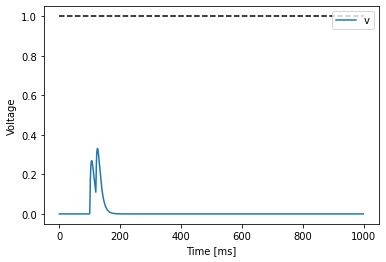

In [193]:
from norse.torch.utils.plot import plot_neuron_states

ax = plot_neuron_states(states, "v")
ax.hlines(y=1.0, xmin=0.0, xmax=1000, linestyle='--', color='k')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage')

As you can see the voltage trace does not reach the default threshold value of ```1.0```. Indeed we can compute the maximal value and timestep at which it is attained:

In [194]:
voltages = torch.stack([s.v for s in states])
max_voltage = torch.max(voltages)
print(f"""maximal value: {max_voltage} 
timestep: {torch.argmax(voltages)} ms
""")

maximal value: 0.33088549971580505 
timestep: 126 ms



Therefore we can simply rescale the input to ellicit at least one output spike (we also now only show the membrane evolution between 0 and 200 ms).

Text(0, 0.5, 'Voltage')

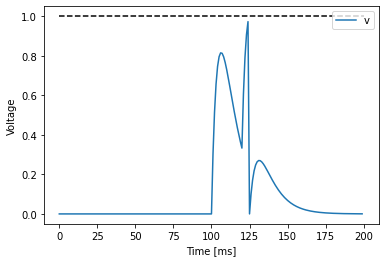

In [195]:
scaled_data = 1.001 * (data / max_voltage) # rescale data according to max voltage + some headroom just computed
output, states = lif(scaled_data[:200]) 

ax = plot_neuron_states(states, "v")
ax.hlines(y=1.0, xmin=0.0, xmax=200, linestyle='--', color='k')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage')

As a small exercise, can you figure out how to visualize the current term (`"i"`)?

# 2. Simulating multiple neurons

A nice feature of the fact that we are using pytorch is that we can easily simulate many neurons at the same time. Here we consider 10000 neurons over 1000 timesteps (that is one second). We do so by generating random spike input as follows

In [216]:
timesteps = 1000 # simulate for 1 second (1 ms timestep)
num_neurons = 1000

input_spikes = torch.rand((timesteps, num_neurons)) < 0.01 # expect ~ 10 input spikes per neuron

We can verify our expectation that there are around $10$ input spikes per neuron by computing

In [217]:
torch.mean(torch.sum(input_spikes, dim=0).float())

tensor(10.2500)

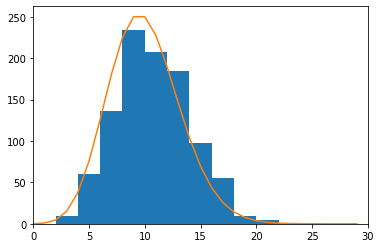

In [253]:
ax = plot_histogram_2d(input_spikes.sum(0))
ax.set_xlim(0,30)

def poisson_fn(lamb, k):
    return lamb**k * torch.exp(- lamb) / ((k + 1).lgamma().exp())

plt.plot(poisson_fn(torch.tensor(timesteps*0.01), torch.arange(0,30)) * 2 * num_neurons)

To run the simulation, we prepare a list of spikes and a state-variable, where the neuron states will be updated in. During the simulation, the states will update independently, resulting in different behaviours.

In [218]:
lif = LIF(p=LIFParameters(v_th=0.3), record_states=True)
spikes, states = lif(input_spikes)

We can visualise the spikes that the neurons produced as follows:

Text(0.5, 0, 'TIme [ms]')

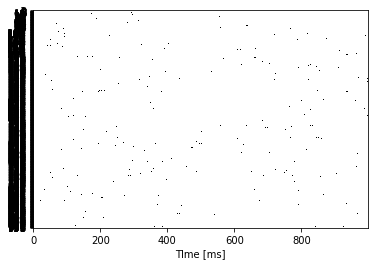

In [219]:
from norse.torch.utils.plot import plot_spikes_2d

ax = plot_spikes_2d(spikes)
ax.set_xlabel('TIme [ms]')

We can compute the number of spikes per neuron again as follows

In [220]:
torch.mean(torch.sum(spikes, dim=0))

tensor(2.6540, grad_fn=<MeanBackward0>)

We gave different inputs for different neurons.
For some neurons, it's clear that the inputs weren't enough to cause any spikes!
For the other neurons, however, there are gradually more spikes as the input current increases.

We can inspect this spike pattern by summing up all the events in the time dimension and look at the individual activity for each neuron:

Text(0.5, 0, 'Spike Count')

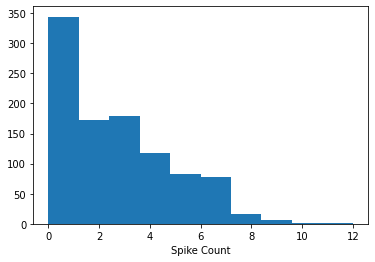

In [221]:
from norse.torch.utils.plot import plot_histogram_2d

ax = plot_histogram_2d(spikes.sum(0))
ax.set_xlabel('Spike Count')

## Conclusion

Hopefully, this tutorial helped you gain some tools to plot spikes and neuron state variables and gave you some pointers on how to gain insights into spiking data in Norse.
There are more [primivites to explore for plotting](https://norse.github.io/norse/norse.torch.utils.html) that we did not get to, but they are relatively simple; the most important thing is to understand the shape and nature of your data, such that you can manipulate it in any way you need.

## Additional resources

Please have a look [at our other notebooks](https://github.com/norse/notebooks) and [our documentation](https://norse.github.io/norse/) - particularly for the [plotting utilities](https://norse.github.io/norse/norse.torch.utils.html).

For an excellent introduction to neuron dynamics and much more, see the [Neuromatch Academy Python tutorial](https://compneuro.neuromatch.io/tutorials/W0D1_PythonWorkshop1/student/W0D1_Tutorial1.html).